In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity

# Loading and Transforming

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()  # Loads the dataset and ignore the labels
x_train = x_train.astype("float32") / 255.0  # Normalizes the training images to the range [0, 1]
x_test = x_test.astype("float32") / 255.0    # Normalizes the test images to the range [0, 1]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
x_train.shape

(60000, 28, 28)

In [4]:
x_test.shape

(10000, 28, 28)

# Adding Noise at Random Locations

In [5]:
def add_noise_random_locations(images, noise_level=0.5, noise_range=[0, 255]):
    """
    Add noise at random locations within the image.

    Parameters:
    images (numpy.ndarray): Input images.
    noise_level (float): The proportion of pixels to add noise to.
    noise_range (list): The range of noise values to add.

    Returns:
    numpy.ndarray: Noisy images with pixel values clipped to [0, 1].
    """
    noisy_images = np.copy(images)
    num_pixels = images.shape[1] * images.shape[2]    # 28 * 28 = 784
    num_noisy_pixels = int(noise_level * num_pixels)  # 50% of 784 = 392

    for i in range(images.shape[0]):
        # Generates random indices to add noise
        noisy_indices = np.random.choice(num_pixels, num_noisy_pixels, replace=False)
        noisy_indices = np.unravel_index(noisy_indices, images.shape[1:])

        # Adds noise within the specified range
        noise = np.random.uniform(noise_range[0], noise_range[1], size=num_noisy_pixels) / 255.0
        noisy_images[i][noisy_indices] = noise

    return np.clip(noisy_images, 0., 1.)   # np.clip(array, min_value, max_value)

In [6]:
# Generate noisy training and test data
x_train_noisy = add_noise_random_locations(x_train)
x_test_noisy = add_noise_random_locations(x_test)

# Convolutional Autoencoder Model

In [7]:
input_img = layers.Input(shape=(28, 28, 1))

In [8]:
# Encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

In [9]:
# Decoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [ ]:
# Creates the autoencoder model
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
print("Autoencoder Model Summary:")
autoencoder.summary()

Autoencoder Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

# Training

In [ ]:
# Reshapes the data to include the channel dimension
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))
x_train_noisy = np.reshape(x_train_noisy, (-1, 28, 28, 1))
x_test_noisy = np.reshape(x_test_noisy, (-1, 28, 28, 1))

In [ ]:
path ='/content/drive/MyDrive/ProgressSoft /Image Noise'

In [ ]:
full_path = os.path.join(path, "training_1")

In [ ]:
os.makedirs(full_path, exist_ok=True)

In [ ]:
# Define the checkpoint callback
checkpoint_path = os.path.join(full_path, "cp.weights.h5")
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_freq='epoch',
    verbose=1
)

In [ ]:
# Train the model with the checkpoint callback
autoencoder.fit(
    x_train_noisy, x_train,
    epochs=40,
    batch_size=256,
    validation_data=(x_test_noisy, x_test),
    callbacks=[checkpoint_callback]
)

Epoch 1/40
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - loss: 0.1511
Epoch 1: saving model to /content/drive/MyDrive/ProgressSoft /Image Noise/training_1/cp.weights.h5
235/235 ━━━━━━━━━━━━━━━━━━━━ 117s 498ms/step - loss: 0.1511 - val_loss: 0.1332
Epoch 2/40
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - loss: 0.1314
Epoch 2: saving model to /content/drive/MyDrive/ProgressSoft /Image Noise/training_1/cp.weights.h5
235/235 ━━━━━━━━━━━━━━━━━━━━ 125s 532ms/step - loss: 0.1314 - val_loss: 0.1236
Epoch 3/40
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - loss: 0.1237
Epoch 3: saving model to /content/drive/MyDrive/ProgressSoft /Image Noise/training_1/cp.weights.h5
235/235 ━━━━━━━━━━━━━━━━━━━━ 140s 526ms/step - loss: 0.1237 - val_loss: 0.1175
Epoch 4/40
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - loss: 0.1174
Epoch 4: saving model to /content/drive/MyDrive/ProgressSoft /Image Noise/training_1/cp.weights.h5
235/235 ━━━━━━━━━━━━━━━━━━━━ 142s 527ms/step - loss: 0.1174 - val_loss: 0.1126
Epoch 5/40
2

In [ ]:
# Save the entire model (architecture + weights + optimizer state)
autoencoder.save("denoising_autoencoder_final.keras")  # Recommended .keras format
# OR
autoencoder.save("denoising_autoencoder_final.h5")     # Legacy HDF5 format
print("Final model saved.")

Final model saved.


# Predictions

In [15]:
# Load the saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/ProgressSoft /Image Noise/Models/denoising_autoencoder_final.keras")

In [17]:
denoised_images = loaded_model.predict(x_test_noisy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step


# Evaluation Metrics

In [18]:
# Reshape the data
x_test = x_test.reshape(-1, 28, 28)  # Original images
denoised_images = denoised_images.reshape(-1, 28, 28)  # Denoised images

# Initializes lists to store metric values
mse_values = []
psnr_values = []
ssim_values = []

# Compute metrics for each image in the test set
for i in range(len(x_test)):
    original_image = x_test[i]
    denoised_image = denoised_images[i]

    # Compute MSE
    mse = mean_squared_error(original_image, denoised_image)
    mse_values.append(mse)

    # Compute PSNR
    psnr = peak_signal_noise_ratio(original_image, denoised_image, data_range=1.0)
    psnr_values.append(psnr)

    # Compute SSIM
    ssim = structural_similarity(original_image, denoised_image, data_range=1.0)
    ssim_values.append(ssim)

# Compute average metrics
avg_mse = np.mean(mse_values)
avg_psnr = np.mean(psnr_values)
avg_ssim = np.mean(ssim_values)

print(f"Average MSE: {avg_mse:.4f}")
print(f"Average PSNR: {avg_psnr:.4f}")
print(f"Average SSIM: {avg_ssim:.4f}")

Average MSE: 0.0094
Average PSNR: 20.5885
Average SSIM: 0.8896


# Visualization of results

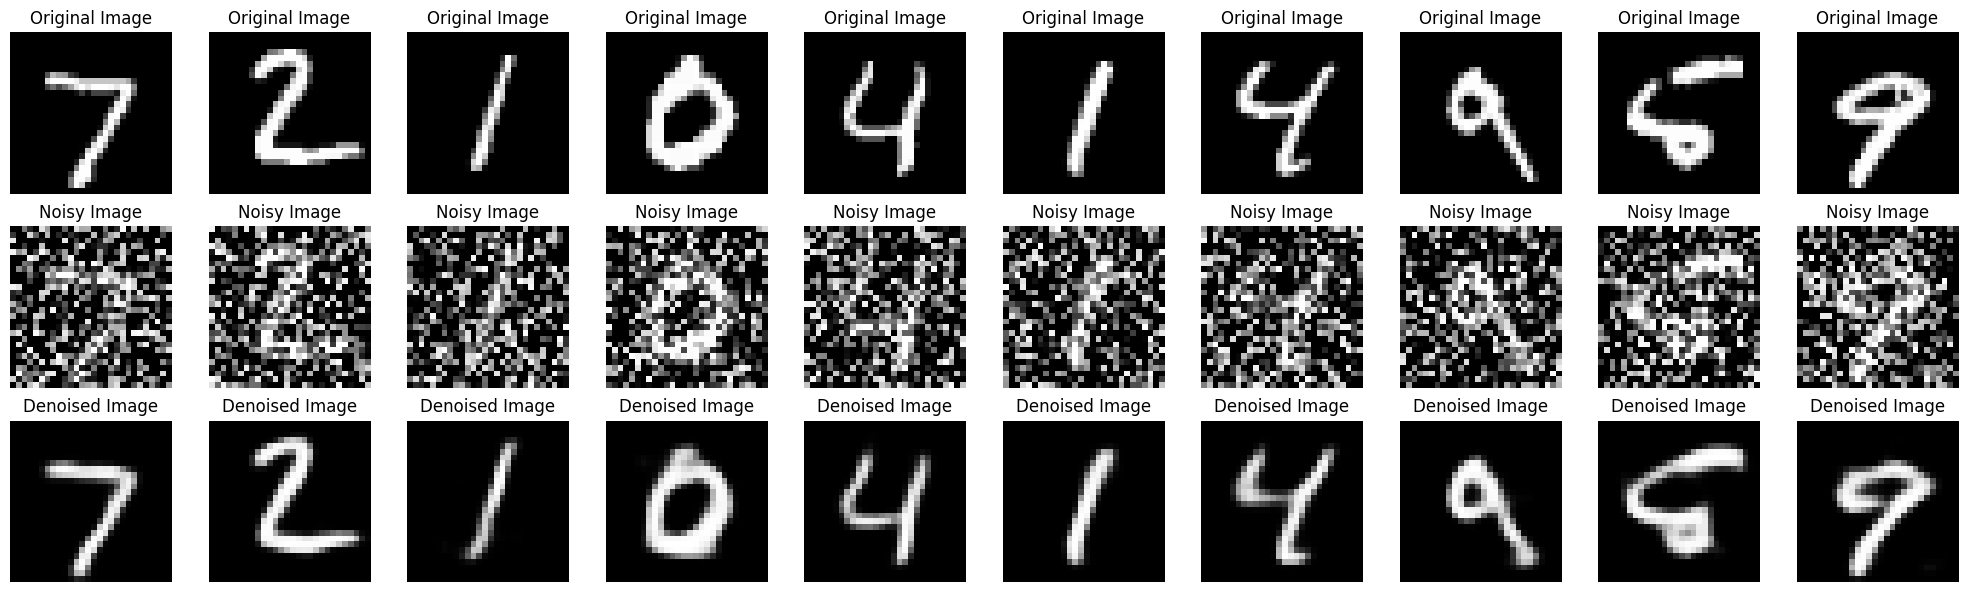

In [19]:
n = 10  # Number of images to display
plt.figure(figsize=(20, 6))

# Original Images
for i in range(n):
    # Display original images
    ax = plt.subplot(3, n, i + 1)  # Create a subplot for the original image
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")  # Display original image
    plt.title("Original Image")
    plt.axis("off")

    # Display noisy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap="gray")
    plt.title("Noisy Image")
    plt.axis("off")

    # Display denoised images
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(denoised_images[i].reshape(28, 28), cmap="gray")
    plt.title("Denoised Image")
    plt.axis("off")

plt.tight_layout()
plt.show()